#TODO
pridat timer aj pri embeddingu, fixnut LLM loopm, hodit do funkcii a prec z ntb do .py suboru tie loopy 

In [1]:
import os

os.chdir("../")
print(os.getcwd())

/app


In [2]:
import pickle
import random
import statistics
import time

import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from tqdm import tqdm
from xgboost import XGBClassifier

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_gpt import GPT4oMini
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI

load_dotenv()
random.seed(42)

In [3]:
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [4]:
law_prompts = pd.read_csv("data/processed/law_prompts.csv")
general_prompts = pd.read_csv("data/processed/general_prompts.csv")
healthcare_prompts = pd.read_csv("data/processed/healthcare_prompts.csv")
finance_prompts = pd.read_csv("data/processed/finance_prompts.csv")

law_dataset = (
    pd.concat([law_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
)
healthcare_dataset = (
    pd.concat([healthcare_prompts, general_prompts])
    .sample(frac=1)
    .reset_index(drop=True)
)
finance_dataset = (
    pd.concat([finance_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
)

datasets = {
    "law": law_dataset,
    "healthcare": healthcare_dataset,
    "finance": finance_dataset,
}

In [5]:
law_prompts_interim = pd.read_csv("data/interim/law_prompts.csv")
general_prompts_interim = pd.read_csv("data/interim/general_prompts.csv")
healthcare_prompts_interim = pd.read_csv("data/interim/healthcare_prompts.csv")
finance_prompts_interim = pd.read_csv("data/interim/finance_prompts.csv")

law_dataset_interim = (
    pd.concat([law_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)
healthcare_dataset_interim = (
    pd.concat([healthcare_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)
finance_dataset_interim = (
    pd.concat([finance_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)

datasets_interim = {
    "law": law_dataset_interim,
    "healthcare": healthcare_dataset_interim,
    "finance": finance_dataset_interim,
}

In [6]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", 
    providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

embedding_models = {
    "mini": mini_embedding,
    "tfidf": tfidf_embedding,
    "baai": baai_embedding,
}

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

2025-02-23 14:42:56.289635525 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-02-23 14:42:56.289896997 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

2025-02-23 14:43:02.164623385 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-02-23 14:43:02.164654049 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [7]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch._dynamo.config.suppress_errors = True # Suppresses warnings in ModernBERT

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Using device: cuda


# GPT and ModernBERT loop using interim data

config.json:   0%|          | 0.00/5.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


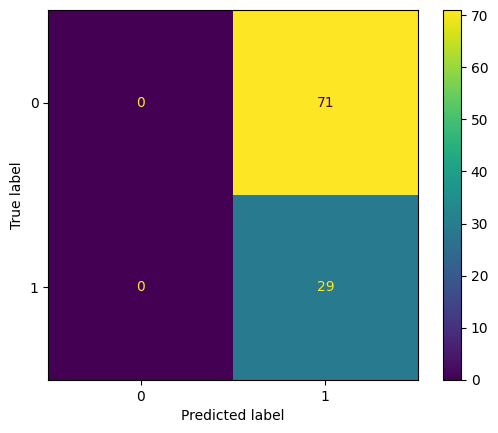

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 100/100 [00:02<00:00, 38.17it/s]


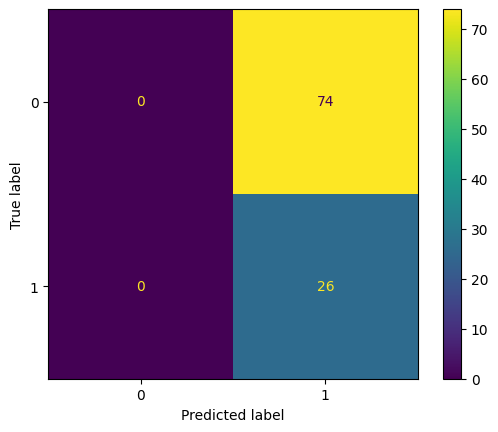

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 100/100 [00:04<00:00, 20.14it/s]


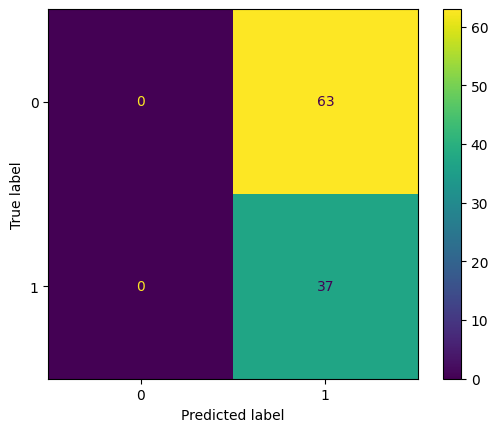

In [8]:
for domain, dataset in datasets_interim.items():
    # Split data
    train_data = dataset.sample(frac=0.00025)
    test_data = dataset.drop(train_data.index).head(100)

    """     
    # GPT Classifier
    gpt_classifier = GPT4oMini(
        api_key=os.getenv("OPENAI_API_KEY"),
        proxy_url=os.getenv("PROXY_URL"),
        model_name="gpt-4o-mini",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )

    # DSPy optimization
    gpt_classifier.optimize_model()

    # Get predictions and metrics for test data
    test_predictions, test_actuals, test_latency = gpt_classifier.predict()

    test_predictions = [int(pred) for pred in test_predictions]
    test_actuals = [int(actual) for actual in test_actuals]
    test_acc = metrics.accuracy_score(test_actuals, test_predictions)

    # Evaluate and save model
    evaluate(
        predictions=test_predictions,
        true_labels=test_actuals,
        domain=domain,
        model_name="gpt4o-mini",
        embed_model="ada-002",
        cost=gpt_classifier.cost,
        latency=test_latency,
        train_acc=test_acc
    )

    gpt_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")
    """

    # ModernBERT Classifier
    bert_classifier = ModernBERTNLI(domain=domain)
    bert_classifier.classifier.model.to("cuda")
    
    # Test predictions
    test_predictions = []
    test_times = []
    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        start_time = time.perf_counter_ns()
        pred = bert_classifier.predict(row["prompt"])
        test_predictions.append(pred)
        test_times.append(time.perf_counter_ns() - start_time)

    test_acc = metrics.accuracy_score(test_data["label"], test_predictions)
    mean_prediction_time = statistics.mean(test_times)

    # Evaluate ModernBERT
    evaluate(
        predictions=test_predictions,
        true_labels=test_data["label"],
        domain=domain,
        model_name="modernbert",
        embed_model="bert-base",
        latency=mean_prediction_time,
        train_acc=test_acc
    )


# SVM, fastText and XGBoost loop using processed data

In [ ]:
def train_and_evaluate_model(
    model_name: str,
    train_embeds: np.ndarray,
    test_embeds: np.ndarray,
    train_labels: pd.Series,
    test_labels: pd.Series,
    domain: str,
    embed_model: str,
    save_path: str,
) -> None:

    # Initialize the classifier
    if model_name == "SVM":
        classifier = SVC(probability=True)
    elif model_name == "XGBoost":
        classifier = XGBClassifier(n_jobs=-1)
    else:
        raise ValueError("Invalid model_name. Choose 'SVM' or 'XGBoost'.")

    print(f"Training {embed_model} embeddings on {domain} domain using {model_name}")

    # Train the model
    classifier.fit(train_embeds, train_labels)

    train_predictions = classifier.predict(train_embeds)
    train_acc = metrics.accuracy_score(train_labels, train_predictions)

    predictions = []
    prediction_times = []

    # Evaluate the model on test data
    for _, test_embed in enumerate(
        tqdm(test_embeds, desc=f"Evaluating {model_name} on {domain}")
    ):
        start_time = time.perf_counter_ns()
        prediction = classifier.predict(test_embed.reshape(1, -1))
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)
        predictions.append(prediction[0])

    mean_prediction_time = statistics.mean(prediction_times)

    # Save the model
    try:
        with open(save_path, "wb") as file:
            pickle.dump(classifier, file)
    except Exception as e:
        print(f"Error saving model: {e}")

    # Evaluate the predictions
    evaluate(
        predictions,
        test_labels,
        domain,
        model_name=model_name,
        embed_model=embed_model,
        latency=mean_prediction_time,
        train_acc=train_acc,
    )

In [ ]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

In [ ]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

In [ ]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.7).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
    fasttext_classifier.train()

    train_predictions = []
    for _, row in train_data.iterrows():
        query = str(row["prompt"]).replace("\n", "")
        prediction = fasttext_classifier.model.predict(query)
        train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

    train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        text = str(row["prompt"])
        query = text.replace("\n", "")

        start_time = time.perf_counter_ns()
        prediction = fasttext_classifier.model.predict(query)
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)

        if prediction[0][0] == "__label__1":
            predictions.append(1)
        else:
            predictions.append(0)

        actuals.append(row["label"])

    mean_prediction_time = statistics.mean(prediction_times)

    evaluate(
        predictions,
        true_labels=actuals,
        domain=domain,
        model_name="fastText",
        embed_model="fastText",
        latency=mean_prediction_time,
        train_acc=train_acc,
    )
    
    fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")

    for model_name, embedding_model in embedding_models.items():
        if model_name == "tf_idf":
            embedding_model.fit(train_data["prompt"])
            with open(f"models/tfidf_{domain}.pkl", "wb") as f:
                pickle.dump(embedding_model, f)
            train_embeds = embedding_model.transform(train_data["prompt"])
            test_embeds = embedding_model.transform(test_data["prompt"])
        else:
            train_embeds = np.array(list(embedding_model.embed(train_data["prompt"])))
            test_embeds = np.array(list(embedding_model.embed(test_data["prompt"])))

    
        # Train and evaluate SVM model
        train_and_evaluate_model(
            model_name="SVM",
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data["label"],
            test_labels=test_data["label"],
            domain=domain,
            embed_model=model_name,
            save_path=f"models/SVM_{domain}_{model_name}.pkl",
        )

        # Train and evaluate XGBoost model
        train_and_evaluate_model(
            model_name="XGBoost",
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data["label"],
            test_labels=test_data["label"],
            domain=domain,
            embed_model=model_name,
            save_path=f"models/XGBoost_{domain}_{model_name}.json",
        )